# Classification of Active Sites using Decision Trees

**Author: [Tony Kabilan Okeke](mailto:tko35@drexel.edu)**

In this assignment, you are going to predict catalytic residues in proteins using sequence and structural information. The dataset (courtesy of Natalia Petrova) is a subset of the data used in "Prediction of catalytic residues using Support Vector Machine with selected protein sequence and structural properties", Natalia Petrova and Cathy Wu, 2006. http://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-7-312

In [1]:
# Import BMES
import sys, os 
sys.path.append(os.environ['BMESAHMETDIR'])
import bmes

# Import other libraries
from sklearn.model_selection import train_test_split
from sklearn import tree
import pandas as pd
import numpy as np

## Load the data

In [2]:
# Download & load data
URL = ('http://sacan.biomed.drexel.edu/lib/exe/fetch.php?rev=&media=course'
       ':ml:d3:hwd3.catsite:catsitedata.xlsx')
file = bmes.downloadurl(URL, 'catsitedata.xlsx')
df = pd.read_excel(file)

# Extract features and labels
X = df.drop('class', axis=1).values
y = df['class'].values
features = df.drop('class', axis=1).columns.tolist()

## Separate the data into training and test sets

You only need to use one of the folds for testing. You do not need to repeat it 
for other folds for this assignment. (In your other machine learning 
assignments/projects, unless otherwise noted, you should use cross-validation 
on all partitions to evaluate performance of a machine learning method).

Use 1/4th of the data for testing and 3/4th for training.

In [3]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Construct Descision Tree for the Training Set

Tree rules:
|--- ScoreConsScore <= 0.76
|   |--- nearest_cleft_SA_area <= 86.65
|   |   |--- W <= 0.50
|   |   |   |--- HB_main_chain_protein <= 2.50
|   |   |   |   |--- C <= 0.50
|   |   |   |   |   |--- H <= 0.50
|   |   |   |   |   |   |--- nearest_cleft_SA_area <= 52.35
|   |   |   |   |   |   |   |--- E <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- E >  0.50
|   |   |   |   |   |   |   |   |--- nearest_cleft_distance <= 3.23
|   |   |   |   |   |   |   |   |   |--- nearest_cleft_distance <= 1.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- nearest_cleft_distance >  1.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- nearest_cleft_distance >  3.23
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- nearest_cleft_SA_area >  52.35
|   |   |   |   |   |   |   |--- T <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |

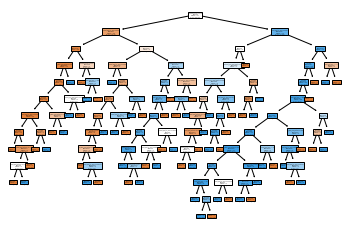

In [7]:
# Construct/train the decision tree
clf_full = tree.DecisionTreeClassifier()
clf_full.fit(X_train, y_train)

# Visualize the tree (graphical view)
tree.plot_tree(clf_full, feature_names=features, filled=True)

# Print out the rule set for the tree
tree_rules = tree.export_text(clf_full, feature_names=features)
print('Tree rules:')
print(tree_rules)

# What are the classification accuracies on the training and test sets?
print('Training accuracy: {:.2f}%'.format(clf_full.score(X_train, y_train)*100))
print('Test accuracy: {:.2f}%'.format(clf_full.score(X_test, y_test)*100))

## Prune the tree

**Use a pruning strategy during construction or a post-pruning method of your choice**

Do not show the trees or the rule set for this section. You do NOT need to 
perform a rigorous analysis for the affects of different pruning strategies or 
parameters. the pruning you choose to employ must have an improved accuracy 
on the test set.

> I will use cost-complexity pruning to (post) prune the tree.

In [8]:
# Prune the tree using your choice of pruning strategy
## Using "cost-complexity pruning" strategy
path = clf_full.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

## Train decision trees for each value of alpha. Select the one with the best
## accuracy on the test set
scores = np.empty(len(ccp_alphas))
for i, ccp_alpha in enumerate(ccp_alphas):
    clf_ = tree.DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf_.fit(X_train, y_train)
    scores[i] = clf_.score(X_test, y_test)

## Train a classifier with the best alpha
best_alpha = ccp_alphas[np.argmax(scores)]
clf_pruned = tree.DecisionTreeClassifier(ccp_alpha=best_alpha)
clf_pruned.fit(X_train, y_train)

# How many nodes were there before pruning and after pruning?
# If you employ a rule-based pruning, answer this question in terms of the
# number of rules before and after pruning.
print('Number of nodes before pruning: {}'.format(clf_full.tree_.node_count))
print('Number of nodes after pruning: {}'.format(clf_pruned.tree_.node_count))

# For the pruned tree, what are the classification accuracies on the training
# and test sets?
print('Training accuracy: {:.2f}%'.format(clf_pruned.score(X_train, y_train)*100))
print('Test accuracy: {:.2f}%'.format(clf_pruned.score(X_test, y_test)*100))

Number of nodes before pruning: 139
Number of nodes after pruning: 41
Training accuracy: 92.04%
Test accuracy: 82.54%
